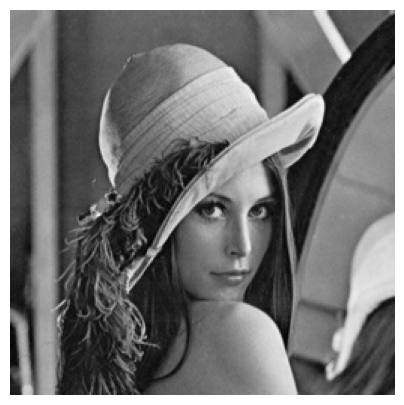

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import tools
import tqdm
import matplotlib
import cv2
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

# 读取灰度图
image = Image.open("lina.jpg").convert('L')  # 替换为你的灰度图路径
resized_image = image.resize((256, 256))

# 显示第四种压缩方法的图像
plt.figure(figsize=(5, 5))
plt.imshow(resized_image, cmap='gray')
plt.axis('off')
plt.show()


In [2]:
import numpy as np
QY = [
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
]
QY = np.array(QY)
QY

array([[ 16,  11,  10,  16,  24,  40,  51,  61],
       [ 12,  12,  14,  19,  26,  58,  60,  55],
       [ 14,  13,  16,  24,  40,  57,  69,  56],
       [ 14,  17,  22,  29,  51,  87,  80,  62],
       [ 18,  22,  37,  56,  68, 109, 103,  77],
       [ 24,  35,  55,  64,  81, 104, 113,  92],
       [ 49,  64,  78,  87, 103, 121, 120, 101],
       [ 72,  92,  95,  98, 112, 100, 103,  99]])

In [3]:
blocks = [
    np.array(resized_image)[j:j + 8, i:i + 8] for j in range(0, 256, 8) for i in range(0, 256, 8)
]

In [29]:
# 探究不同参数对结果的影响
# 生成探究的参数列表
mask_sizes = range(8 * 2)  # 可根据具体需求修改
mask_radios = []

# 初始化结果存储的列表
mse_values = []
psnr_values = []

# 原始图像
original_image = np.array(resized_image)

# 循环不同的探究参数
for mask_size in tqdm.tqdm(mask_sizes, "mask进度"):
    # 使用当前参数处理图像
    compressed_signals_2_1 = []
    mask, mask_radio = tools.generate_slant_mask(mask_size)
    mask_radios.append(mask_radio)
    for block in blocks:
        # dct_block = tools.dct2d(block)
        dct_block = cv2.dct(block.astype('float32'))
        dct_block = mask * dct_block
        quantized_block = np.round(dct_block / QY)  # 量化
        zigzag_result = tools.zigzag_scan(quantized_block)  # ZigZag扫描
        compressed_dct_signal = tools.dpcm_encode(zigzag_result)  # DPCM编码
        compressed_signals_2_1.append(compressed_dct_signal)

    # 重建图像
    # 逆DCT重建压缩后的图像
    reconstructed_image_2_1 = np.zeros((256, 256))

    for idx, signal in enumerate(compressed_signals_2_1):
        y, x = divmod(idx, 32)
        decode_signal = tools.dpcm_decode(signal)
        reconstructed_matrix = tools.zigzag_reverse(decode_signal, 8, 8)
        # reconstructed_image_2_1[y * 8:y * 8 + 8, x * 8:x * 8 + 8] = tools.idct2d(reconstructed_matrix * QY)
        reconstructed_image_2_1[y * 8:y * 8 + 8, x * 8:x * 8 + 8] = cv2.idct(reconstructed_matrix * QY)

    # 计算MSE和PSNR
    mse = tools.mse(original_image, reconstructed_image_2_1)
    psnr = tools.psnr(original_image, reconstructed_image_2_1)

    # 存储结果
    mse_values.append(mse)
    psnr_values.append(psnr)

    # # 显示当前参数下的重建图像
    # plt.figure(figsize=(5, 5))
    # plt.imshow(reconstructed_image_2_1.astype('uint8'), cmap='gray')
    # plt.title(f'方法2.1: 掩模尺寸 {mask_size}\nMSE: {mse:.2f}, PSNR: {psnr:.2f}')
    # plt.axis('off')
    # plt.show()

mask进度: 100%|██████████| 16/16 [00:01<00:00, 14.60it/s]


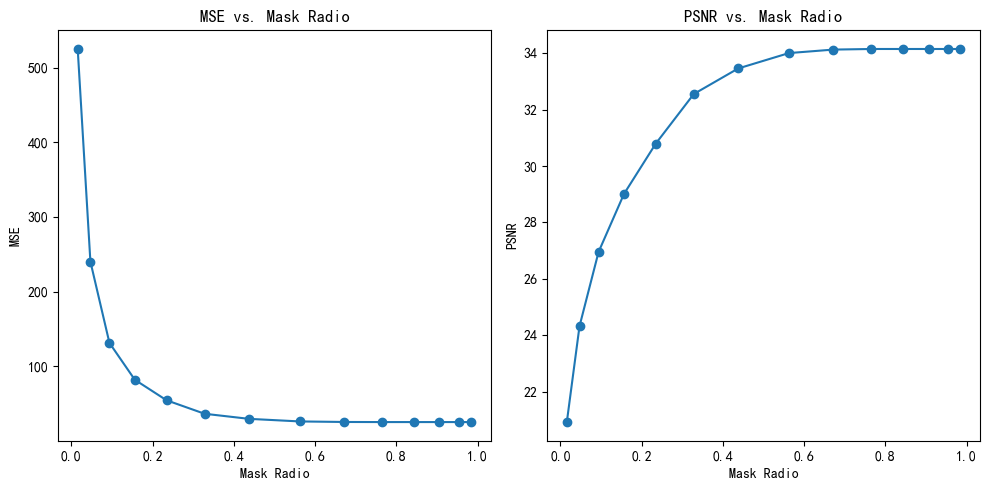

In [13]:
# 可视化结果
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(mask_radios, mse_values, marker='o')
plt.title('MSE vs. Mask Radio')
plt.xlabel('Mask Radio')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.plot(mask_radios, psnr_values, marker='o')
plt.title('PSNR vs. Mask Radio')
plt.xlabel('Mask Radio')
plt.ylabel('PSNR')

plt.tight_layout()
plt.show()


In [9]:
import cv2
# 缩放为256x256的量化表
QY_256 = cv2.resize(cv2.merge([QY.astype(np.uint8)]), (256, 256), interpolation=cv2.INTER_LINEAR)

# 将OpenCV数组转换为Numpy数组
QY_256 = np.array(QY_256)

QY_256

array([[16, 16, 16, ..., 61, 61, 61],
       [16, 16, 16, ..., 61, 61, 61],
       [16, 16, 16, ..., 61, 61, 61],
       ...,
       [72, 72, 72, ..., 99, 99, 99],
       [72, 72, 72, ..., 99, 99, 99],
       [72, 72, 72, ..., 99, 99, 99]], dtype=uint8)

In [30]:
dct_select = cv2.dct(np.array(resized_image).astype('float32'))

mask_sizes = range(256 * 2)  # 可根据具体需求修改
mask_radios_2 = []

# 初始化结果存储的列表
mse_values_2 = []
psnr_values_2 = []

for mask_size in tqdm.tqdm(mask_sizes, "mask进度"):
    mask, mask_radio = tools.generate_slant_mask(mask_size, m=256)
    dct_select_masked = mask * dct_select  # 除原点外，自行选择保留有限个交流分量
    mask_radios_2.append(mask_radio)

    quantized_result = np.round(dct_select_masked / QY_256)  # 量化
    zigzag_result = tools.zigzag_scan(quantized_result)  # ZigZag
    compressed_dct_full = tools.dpcm_encode(zigzag_result)  # DPCM

    decode_signal = tools.dpcm_decode(compressed_dct_full)
    reconstructed_matrix = tools.zigzag_reverse(decode_signal, 256, 256)
    reconstructed_image_2_4 = cv2.idct(reconstructed_matrix * QY_256)  # IDCT

        # 计算MSE和PSNR
    mse = tools.mse(original_image, reconstructed_image_2_4)
    psnr = tools.psnr(original_image, reconstructed_image_2_4)

    # 存储结果
    mse_values_2.append(mse)
    psnr_values_2.append(psnr)

    # # 显示第四种压缩方法的图像
    # plt.figure(figsize=(5, 5))
    # plt.imshow(reconstructed_image_2_4.astype('uint8'), cmap='gray')
    # plt.title('Method 2.4: Selective AC coefficient preservation')
    # plt.axis('off')
    # plt.show()


mask进度: 100%|██████████| 512/512 [00:30<00:00, 16.90it/s]


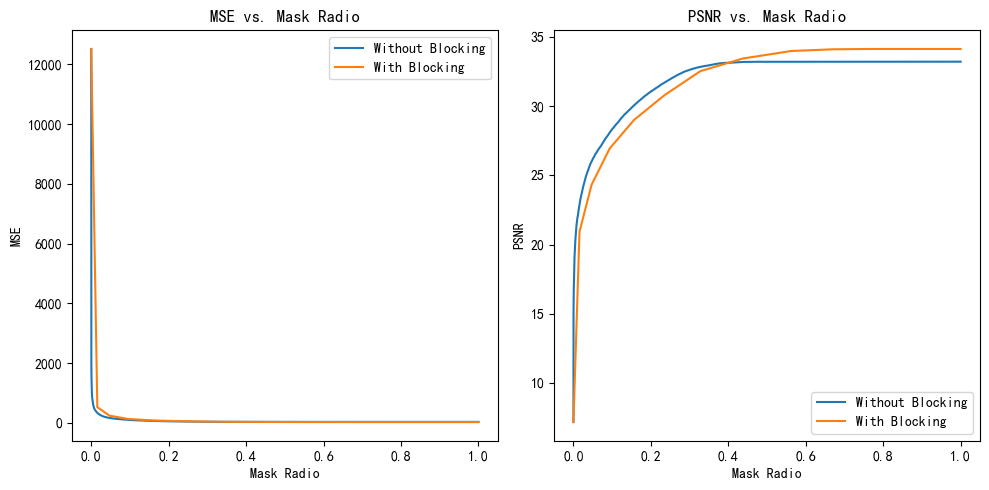

In [32]:
# 可视化结果
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(mask_radios_2, mse_values_2, label='Without Blocking')
plt.plot(mask_radios, mse_values, label='With Blocking')
plt.title('MSE vs. Mask Radio')
plt.xlabel('Mask Radio')
plt.ylabel('MSE')
plt.legend()  # 添加图例

plt.subplot(1, 2, 2)
plt.plot(mask_radios_2, psnr_values_2, label='Without Blocking')
plt.plot(mask_radios, psnr_values, label='With Blocking')
plt.title('PSNR vs. Mask Radio')
plt.xlabel('Mask Radio')
plt.ylabel('PSNR')
plt.legend()  # 添加图例

plt.tight_layout()
plt.show()
